# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [266]:
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from asl_data import AslDb
from IPython.display import display
import math


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [267]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [268]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [269]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']


# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [270]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [271]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [272]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [273]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [274]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [275]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [276]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# First, finish mapping df_mean entries to asl.df columns (asl.df['left-x-mean'] already done 2 cells above)
asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])

# Second, map df_std entries to asl.df.columns
asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

# Third, map the four norm features to asl.df from its three terms
asl.df['norm-rx'] = ( asl.df['right-x'] - asl.df['right-x-mean']) / (asl.df['right-x-std'])
asl.df['norm-ry'] = ( asl.df['right-y'] - asl.df['right-y-mean']) / (asl.df['right-y-std'])
asl.df['norm-lx'] = ( asl.df['left-x'] - asl.df['left-x-mean']) / (asl.df['left-x-std'])
asl.df['norm-ly'] = ( asl.df['left-y'] - asl.df['left-y-mean']) / (asl.df['left-y-std'])

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [277]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

# First, add the right and left radius/vector length factors of the Cartesian-to-Polar-Coordinates mapping
asl.df['polar-rr'] = np.sqrt(((asl.df['grnd-rx']**2) + (asl.df['grnd-ry']**2)))
asl.df['polar-lr'] = np.sqrt(((asl.df['grnd-lx']**2) + (asl.df['grnd-ly']**2)))

# Second, the right and left angular factors of the Cartesian-to-Polar-Coordinates mapping
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [278]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

# Add single differentials for each hand wrt nose/origin
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0.0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0.0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0.0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0.0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
display(asl.df.head())

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr    polar-lr  polar-rtheta  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784  119.603512      0.079478     -0.100501       0.0   
      1      113.35784  119.603512      0.079478     -0.100501       0.0   
      2      113.35784  119.603512      0.079478     -0.100501       0.0   
      3      113.35784  119.603512      0.079478     -0.100501       0.0   
      4      113.35784  119.603512      0.079478     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [279]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# Consider the normalized delta quantities for each of the four differentials
# together with features_polar
features_norm_delta = ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ly']
features_custom = features_norm_delta + features_polar

# TODO define a list named 'features_custom' for building the training set

# First calculate the means of each of the four differentials
mean_delta_rx = asl.df['delta-rx'].mean()
mean_delta_ry = asl.df['delta-ry'].mean()
mean_delta_lx = asl.df['delta-lx'].mean()
mean_delta_ly = asl.df['delta-ly'].mean()

# Second calculate the standard deveiations of the four differentials
std_delta_rx = asl.df['delta-rx'].std()
std_delta_ry = asl.df['delta-ry'].std()
std_delta_lx = asl.df['delta-lx'].std()
std_delta_ly = asl.df['delta-ly'].std()

# Third, add a column for each of the normalized differential
asl.df['norm-delta-rx'] = (asl.df['delta-rx'] - mean_delta_rx)/std_delta_rx
asl.df['norm-delta-ry'] = (asl.df['delta-ry'] - mean_delta_ry)/std_delta_ry
asl.df['norm-delta-lx'] = (asl.df['delta-lx'] - mean_delta_lx)/std_delta_lx
asl.df['norm-delta-ly'] = (asl.df['delta-ly'] - mean_delta_ly)/std_delta_ly


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**  

    I chose to examaine normalized deltas, together with feaures_polar.   We have the indirect benefit of domain experience, from Thad's videos noting that delta, or change in Cartesian measure from one frame to the next, was more valuable information than simple, Cartesian location at time certain alone.   Normalizing, furthermore, allows for single variables/features, including these new four, to be scaled and, thus, not dominate fitting and modeling.  Additionally, features_polar capture time-series-like data well, as further explained directly below.  Finally, deriving these four new data is computationally inexpensive and seemingly quite relavant at the same time.
    I chose to incorporate the four features from features_polar, as well.   Speech, including signed speech, is structurally, in essence, a time series.   True sound waves are most often well represented as sinusoidal wave propogation or through other, similar transcendental fuctions.   Polar coordinates well encapsulate such 2D wave-like pheonoma, as the system's basis vectors are r*cos_theta and r*sin_theta.
    Finally, intuitively, I thought the eight features caputured nuances not derived from either of the two four-element feature sets.   Capturing absolute, Cartesian-based motion as a function of time (i.e., change of sequential frame), together with angular motion, seemed more fitting - no pun intended - for the dataset.   The eight together encapsulate reasonably to where a given hand is moving, as well as angular position of each wrt the crown of the speaker's head.  This encodes a topology reflecting state changes that embody both simple Carterian motion, a natural for a flat image, as well as angular position wrt top of head, effectively the origin.   The latter allows for accommodation for differing arm lengths, nose position in the image, etc. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [280]:
import unittest

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [281]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [282]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [283]:
my_testword = 'CHOCOLATE'

model, logL = train_a_word(my_testword, 5, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ -1.29531828e-01  -4.71125082e-02   1.42792771e-05   0.00000000e+00
   5.24333602e+01  -1.67733816e-01   6.92603783e+01   8.67383387e-02]
variance =  [ 0.87262454  0.00890043  0.00125     0.00125     1.11898635  0.00393347
  0.00125     0.00125   ]

hidden state #1
mean =  [  2.43627786e-03   7.00365051e-02  -7.57575416e-02   2.53808073e-01
   8.50167047e+01   2.72500350e-02   1.01810178e+02   1.08809468e-01]
variance =  [  1.10577166e+00   2.01266845e-01   7.31072467e-01   6.62360344e-01
   1.02607500e+01   3.30034755e-03   2.38126286e+01   5.10933449e-03]

hidden state #2
mean =  [  2.36240023e-01   1.87733899e-01   5.77694272e-04  -1.36681837e+00
   5.33095751e+01  -9.92821621e-02   9.63794046e+01   3.99136389e-02]
variance =  [  1.50781153e-01   4.16092481e-02   3.19271056e-01   8.08160645e-01
   1.45755909e+01   5.65298149e-03   2.23931163e+02   3.17301535e-03]

hidden state #3
mean =  [ -1.62572719e-01 

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [284]:
%matplotlib inline

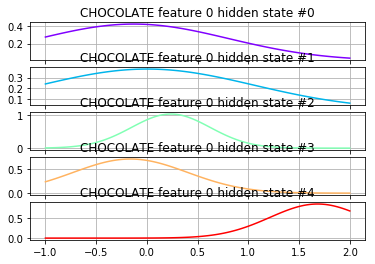

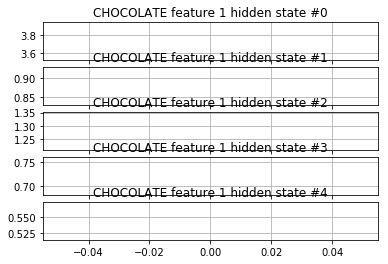

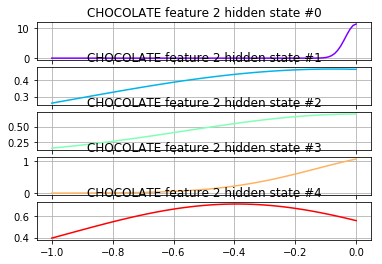

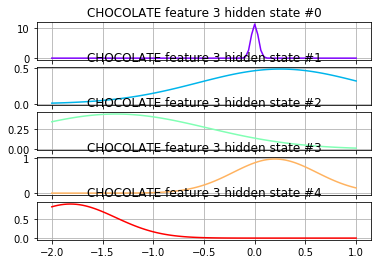

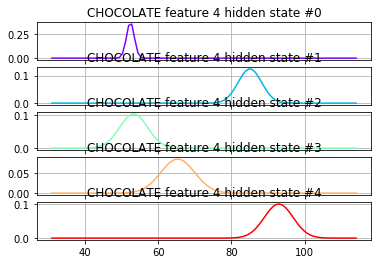

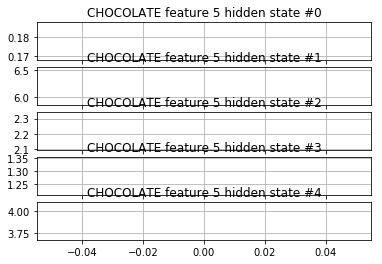

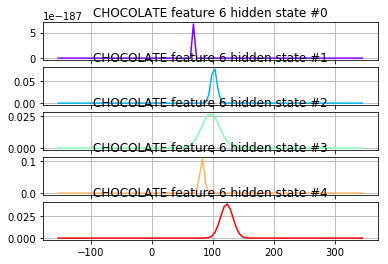

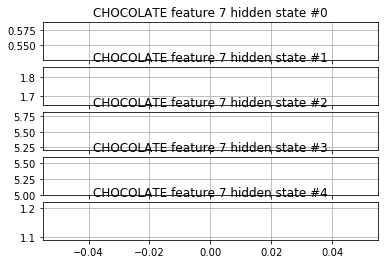

In [285]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [286]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [287]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [288]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [289]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.02789437200408429 seconds
Training complete for BOOK with 15 states with time 2.075579615018796 seconds
Training complete for VEGETABLE with 15 states with time 0.720621430024039 seconds
Training complete for FUTURE with 15 states with time 2.1670577389886603 seconds
Training complete for JOHN with 15 states with time 20.60101169196423 seconds


In [291]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.08979449496837333 seconds
Training complete for BOOK with 8 states with time 1.8831171639612876 seconds
Training complete for VEGETABLE with 11 states with time 0.6996526250150055 seconds
Training complete for FUTURE with 9 states with time 2.048287678975612 seconds
Training complete for JOHN with 14 states with time 20.75334162998479 seconds


In [292]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.0888855560333468 seconds
Training complete for BOOK with 5 states with time 1.8654860010137782 seconds
Training complete for VEGETABLE with 5 states with time 0.6742619889555499 seconds
Training complete for FUTURE with 5 states with time 1.9881156199844554 seconds
Training complete for JOHN with 5 states with time 18.984806383028626 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
    
    SelectorConstant:   The primary advantage of this model selector is its simplicity and thus its speed.  In addition, it ensures that the number of states is under the control of the scientist and equal to the number of components, which smacks, at least viscerally, of internally consistent logic.
    The primary disadvantage of this model estimator is, of course, its rigidity.   By assuming what is, in essence, a square world (i.e., with n_components=num_states) it assumes a relevance of each resultant node at each resultant state and state change.   In the process, it does not allow, in particular, penalties for extraneous information and larger-magitude awards for larger information gains.
   
    SelectorBIC:  Bayesian Information Criterion ("BIC") is the mirror image of SelectorConstant, insofar as the final point above.   The final term of a BIC score in its most common form, log(n) X (p + 1), is a penalty, while its preceding components can be regarded as caputuring the sum of the squares residual ("SSRES") of the response variable, the probability of the classification in the instant case. Ramsey F., Schafer D. (2013.  The Statistical Sleuth, A Course in Methods of Data Analyais (3rd ed.)  Boston, MA: Brooks/Cole CENGAGE Learning, pp. 361 - 366.  By not fixing topological dimensionality, BIC is a true maximum likelihood estimator ("MLE").  BIC attaches a relevance to a feature towards the endgame goal; in keeping, e.g., with a kernel density estimator ("KDE") BIC seeks to find the "true" underling structure/distribution of the vocabulary decomposed into its hidden component parts while mitigating complexity, together with its possible resultant overfitting.
    The primary disadvantages of BIC lie in the fact that it is largely a heuristic.   The disaggregation of the BIC score itself shows a positive and a penalty component.   While neither is, of course, arbitrary the BIC heuristic differs from Akaike Information Criterion ("AIC") largely because the two are, by design, heuristics with somewhat different emphases.   The BIC penalty component is larger than that of AIC for all sample sizes large than 7.   (Ibid).   It is not uncommon for statisiticians to use both, and, in fact, I have added AIC in my_model_selectors.py.   As a result of these differences, it is quite possible for AIC to produce a model different from BIC, especially when faced with many features with interactions/higher correlations.
    
    SelectorDIC:  The Discriminative Information Criterion ("DIC") selector can be regarded as SelectorConstant, except that it looks for the relevance of component or, more precisely, of an incremental number of components.  It does so by singly looking at SelectorConstant iteratively, with one component removed each time.   It's primary advantages, as a result, are largely the same as those for SelectorConstant, but DIC refines the calculations a bit.  It does so, in essence, with a K-fold cross-validation.
    As for disadvantages, DIC shares those with SelectorConstant.   In addition, an ostensible K-fold cross validation, while helping to determine component relevance, is a heuristic, with the consequent shortcoming of the BIC equation above.
    
    SelectorCV:  SelectorCV is a true cross-validation ("CV"), inasmuch as combinations of features are aggregated randomly, scored, and averaged.   This allows for mitigation of misleading signals in the data - ostensibly alpha risk.  In this problem, the first step is accomplished via the provided asl_utils.combine_sequences.
    The primary disadvantages of CV here is its use of the base_model (SelectorConstant) and the fact that CV itself is also a heuristic.  As such, CV shares the disadvantages of SelectorCV and those of the BIC equation itself.  One can test, however, with differing numbers of folds, e.g., but that process itself is "proof" by trial-and-error, not by mathematical rigor. 
    The primary advantage of CV here is the random selections of combinations.  Randomness of assignment (to a tested set) is, in fact, the only step short of showing even causality.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [293]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 39.811s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [294]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=5).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [295]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [296]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [297]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5617977528089888
Total correct: 78 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
    7: JOHN *WHAT GO *BOX                                            JOHN CAN GO CAN
   12: *IX *WHAT *CAN CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE *JOHN *FUTURE *CAR *CAR *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO IX *WHO IX                                          JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY *MARY                                    JOHN LIKE IX IX IX
   36: MARY VEGETABLE *YESTERDAY *GIVE *MARY *MARY                   MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *GIVE MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [298]:
# TODO Choose a feature set and model selector
features = features_polar
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: *GO *BROTHER *GIVE1                                           JOHN WRITE HOMEWORK
    7: *MARY *BOX *IX *ARRIVE                                        JOHN CAN GO CAN
   12: JOHN *WHAT *CAR CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *PREFER *GIVE1 *TEACHER *FUTURE *WHO           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *FUTURE *WHO IX                                    JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE IX IX                                       JOHN LIKE IX IX IX
   30: *GO LIKE *MARY *MARY IX                                       JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE *GO *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *APPLE MARY *MARY                                JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE        

In [299]:
# TODO Choose a feature set and model selector
from my_model_selectors import SelectorBIC, SelectorAIC
from copy import deepcopy
features = features_custom
model_selector = SelectorBIC
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
models_best = models
test_set = asl.build_test(features)
test_set_best = test_set
probabilities, guesses = recognize(models, test_set)
probabilities_best = deepcopy(probabilities)
guesses_best = (guesses)
show_errors(guesses, test_set)

# N.B.: The above does, in fact, derive proabilities_best & guesses_best
# I have proven this in the below 2 cells 


**** WER = 0.46629213483146065
Total correct: 95 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *BOX GO *ARRIVE                                          JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *ARRIVE WONT *MARY *BUY *CAR *FUTURE *WHO                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *JOHN IX *JOHN                                      JOHN LIKE IX IX IX
   28: JOHN *WHO IX *JOHN IX                                         JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY IX IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *GIVE *GIVE *MARY *JOHN                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE        

In [300]:
# EVALUATE ALL COMBINATIONS OF FEATURES AND MODEL_SELECTORS TO FIND OPTIMAL PAIRING
from asl_data import SinglesData, WordsData
# First, define a function to return the model_selector class name as a string
def get_model_selector_classname(model_selector_class):
    return model_selector_class.__name__

# Second, define a function to return the features name as a string
# Based upon https://stackoverflow.com/questions/12693606/
#     reason-for-globals-in-python
def get_features_name(features_list): 
    for key, value in globals().items():
        if type(value) == list and value == features_list:
            return key
        
# Third, define a function to concatenate all pairings of features 
#    and model_selectors
def features_models_concatname(features_names, model_names):
    feature_model_name_combos = []
    feature_model_name = str()
    for features_name in features_names:
        for model_name in model_names:
            feature_model_name = features_name.strip() + ' + ' + model_name.strip()
            feature_model_name_combos.append(feature_model_name)
    return feature_model_name_combos


# Fourth, build lists for optimal features & model_selector combo search
features_list = [features_ground, features_norm, features_polar, features_delta, \
                 features_custom]
model_selector_list = [SelectorConstant, SelectorBIC, SelectorDIC, SelectorCV, SelectorAIC]
model_selector_list_names = [get_model_selector_classname(model_selector) \
                             for model_selector in model_selector_list]
features_list_names = [get_features_name(features) for features in features_list]
feature_model_list = features_models_concatname(features_list_names, \
                        model_selector_list_names)
feature_model_WERs = []

# Fifth, define a function like show_erors excl. extraneous output & harvesting results
def evaluate_combo(combo_name : str, guesses : list, test_set : SinglesData, WER_best : float, \
                   sentences_best_guess = []):
    recognized_sentence = recognized_sentences = correct_sentences = correct_sentence = []
    global feature_model_WERs
    WER = float(1) # Initialize at 1 = 100% = every word guess wrong
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1
    WER = float(S) / float(N)
    feature_model_WERs.append(WER)
    print("\n**** WER for {} = {}".format(WER, combo_name))
    print("Total correct: {} out of {}".format(N - S, N))
    if WER < WER_best:
        WER = float(WER_best)
    for video_num in test_set.sentences_index:
        correct_sentence = [test_set.wordlist[i] for i in test_set.sentences_index[video_num]]
        recognized_sentence = [guesses[i] for i in test_set.sentences_index[video_num]]
        recognized_sentences.append(recognized_sentence)
        sentences_best_guess.append(recognized_sentence)
    return WER, WER_best, recognized_sentences, sentences_best_guess, correct_sentences

# Sixth, define a function to gauge and capture optimal data members during iteration
def track_the_data(combination_name : str, WER : float, WER_best : float, \
            recognized_sentences : list, sentences_best_guess : list, correct_sentences : list):
    combination_best = combination_name
    WER_best = float(WER)
    if len(sentences_best_guess) > 0:
        for sentence in sentences_best_guess:
            if len(sentence) > 0:
                del(sentence[:])
    if len(sentences_best_guess) > 0:           
        del(sentences_best_guess[:])
    for recognized_sentence in recognized_sentences:
        sentences_best_guess.append(recognized_sentence)
    return combination_best, WER_best, sentences_best_guess, correct_sentences
        
# Seventh, through exhaustive search find the optimal (lowest WER) feature-model combination
WER_best = float(1) # Initialize at 1 ~ 0% accuracy ~ every word guess wrong
for feature_idx, features in enumerate(features_list):
    for model_idx, model_selector in enumerate(model_selector_list):
        guesses = recognized_sentences = recognized_sentences = []
        feature_model_idx = feature_idx * len(model_selector_list) + model_idx
        combination_name = feature_model_list[feature_model_idx]
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        WER, WER_best, recognized_sentences, sentences_best_guess, correct_sentences = \
            evaluate_combo(combination_name, guesses, test_set, WER_best)
        if WER < WER_best:
            combination_best, WER_best, sentences_best_guess, correct_sentences = \
            track_the_data(combination_name, WER, WER_best, recognized_sentences, \
                           sentences_best_guess, correct_sentences)

WER_best = min(feature_model_WERs)
best_WER_idx = feature_model_WERs.index(WER_best)
combination_best = feature_model_list[best_WER_idx]
print("\nThe winning features-model_selector was {} with WER of {}".format(combination_best, WER_best))
print("\nThe sentences_best_guess were:")
display(sentences_best_guess)
print("The length of sentences_best_guess was {}".format(str(len(sentences_best_guess))))
print("\nThe correct_sentences were:")
display(correct_sentences)
print("The length of correct_sentences was {}".format(str(len(correct_sentences))))                                            


**** WER for 0.5617977528089888 = features_ground + SelectorConstant
Total correct: 78 out of 178

**** WER for 0.5561797752808989 = features_ground + SelectorBIC
Total correct: 79 out of 178

**** WER for 0.5617977528089888 = features_ground + SelectorDIC
Total correct: 78 out of 178

**** WER for 0.5786516853932584 = features_ground + SelectorCV
Total correct: 75 out of 178

**** WER for 0.5561797752808989 = features_ground + SelectorAIC
Total correct: 79 out of 178

**** WER for 0.5561797752808989 = features_norm + SelectorConstant
Total correct: 79 out of 178

**** WER for 0.6404494382022472 = features_norm + SelectorBIC
Total correct: 64 out of 178

**** WER for 0.5561797752808989 = features_norm + SelectorDIC
Total correct: 79 out of 178

**** WER for 0.6067415730337079 = features_norm + SelectorCV
Total correct: 70 out of 178

**** WER for 0.6235955056179775 = features_norm + SelectorAIC
Total correct: 67 out of 178

**** WER for 0.550561797752809 = features_polar + SelectorCon

[['JOHN', 'WRITE', 'NEW'],
 ['JOHN', 'WHAT', 'GO', 'BOX'],
 ['IX', 'WHAT', 'CAN', 'CAN'],
 ['JOHN', 'ARRIVE', 'JOHN', 'FUTURE', 'CAR', 'CAR', 'FUTURE', 'WHO'],
 ['JOHN', 'LIKE', 'LOVE', 'WHO', 'IX'],
 ['JOHN', 'WHO', 'IX', 'WHO', 'IX'],
 ['IX', 'LIKE', 'MARY', 'MARY', 'MARY'],
 ['MARY', 'VEGETABLE', 'YESTERDAY', 'GIVE', 'MARY', 'MARY'],
 ['MARY', 'IX', 'GIVE', 'MARY', 'MARY'],
 ['JOHN', 'SHOULD', 'BUY', 'HOUSE'],
 ['POSS', 'SEE', 'BUY', 'CAR', 'JOHN'],
 ['JOHN', 'SHOULD', 'NOT', 'BUY', 'HOUSE'],
 ['MARY', 'VISIT', 'VISIT', 'MARY'],
 ['JOHN', 'SOMETHING-ONE', 'WOMAN', 'BUY', 'HOUSE'],
 ['JOHN', 'FUTURE', 'GIVE1', 'MARY'],
 ['IX', 'CORN', 'IX', 'MARY'],
 ['JOHN', 'BLAME', 'LOVE'],
 ['LOVE', 'ARRIVE', 'GIVE1', 'VIDEOTAPE'],
 ['SHOULD', 'POSS', 'IX', 'IX', 'IX', 'ARRIVE', 'BOOK'],
 ['POSS', 'IX', 'IX', 'SOMETHING-ONE', 'JOHN', 'ARRIVE'],
 ['JOHN', 'GIVE', 'IX', 'IX', 'WOMAN', 'BOOK'],
 ['POSS', 'NEW', 'CAR', 'BREAK-DOWN'],
 ['JOHN', 'VEGETABLE'],
 ['JOHN', 'GO', 'JOHN', 'GO', 'MARY'],
 ['S

The length of sentences_best_guess was 1000

The correct_sentences were:


[['JOHN', 'WRITE', 'HOMEWORK'],
 ['JOHN', 'CAN', 'GO', 'ARRIVE'],
 ['JOHN', 'CAN', 'JOHN', 'CAN'],
 ['JOHN', 'ARRIVE', 'WONT', 'MARY', 'BUY', 'CAR', 'FUTURE', 'MARY'],
 ['JOHN', 'LIKE', 'JOHN', 'IX', 'JOHN'],
 ['JOHN', 'WHO', 'IX', 'JOHN', 'IX'],
 ['JOHN', 'LIKE', 'MARY', 'IX', 'IX'],
 ['MARY', 'JOHN', 'GIVE', 'GIVE', 'MARY', 'JOHN'],
 ['JOHN', 'IX', 'JOHN', 'JOHN', 'MARY'],
 ['JOHN', 'JOHN', 'BUY', 'HOUSE'],
 ['JOHN', 'PREFER', 'BUY', 'CAR', 'JOHN'],
 ['JOHN', 'FUTURE', 'FUTURE', 'BUY', 'HOUSE'],
 ['JOHN', 'JOHN', 'IX', 'MARY'],
 ['JOHN', 'FUTURE', 'MARY', 'BUY', 'HOUSE'],
 ['JOHN', 'FUTURE', 'GIVE1', 'MARY'],
 ['IX', 'MARY', 'IX', 'MARY'],
 ['JOHN', 'BLAME', 'MARY'],
 ['JOHN', 'JOHN', 'GIVE1', 'BOOK'],
 ['JOHN', 'IX', 'IX', 'IX', 'IX', 'NEW', 'BOOK'],
 ['JOHN', 'IX', 'IX', 'SOMETHING-ONE', 'IX', 'BOOK'],
 ['JOHN', 'IX', 'IX', 'WOMAN', 'IX', 'BOOK'],
 ['POSS', 'NEW', 'CAR', 'BREAK-DOWN'],
 ['JOHN', 'SEE'],
 ['JOHN', 'IX', 'BOOK', 'MARY', 'JOHN'],
 ['JOHN', 'ARRIVE'],
 ['IX', 'CAR', 'J

The length of correct_sentences was 40


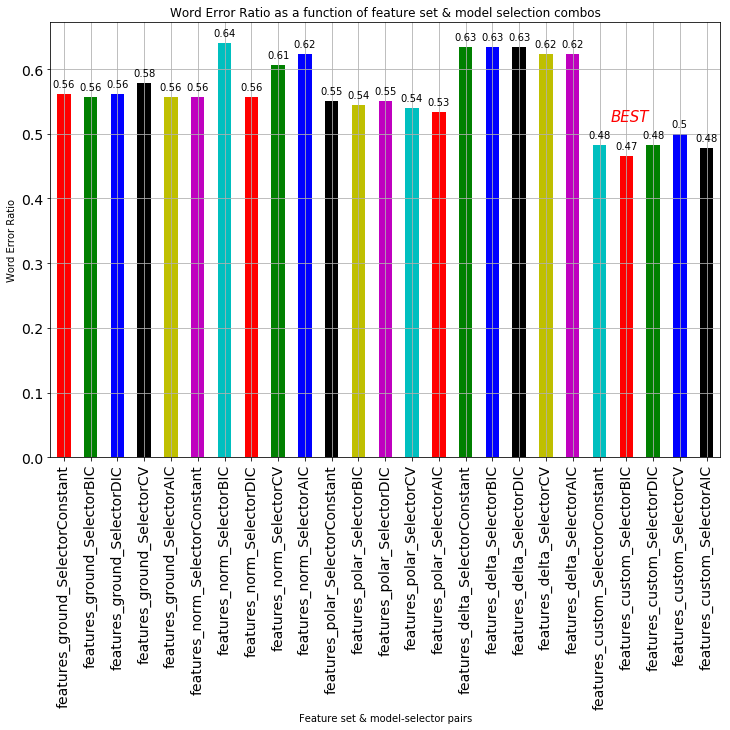

In [301]:
# VISUALIZE THE RESULTS OF THE PAIRINGS COMPARISIONS
import matplotlib.pyplot as plt
plt.clf()
column_names = [name.replace(' ', '').replace('+','_') for name in feature_model_list]
my_colors = 'rgbkymc'
# Based upon http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
df2 = pd.DataFrame([y for y in feature_model_WERs], [x for x in column_names])
plt.figure()
ax = df2.plot(kind='bar', figsize=(12,8), \
              title='Word Error Ratio as a function of feature set & model selection combos', \
              grid=True, stacked=True, color=my_colors, sort_columns=False, legend=False, fontsize=14)
ax.set_xlabel("Feature set & model-selector pairs")
ax.set_ylabel("Word Error Ratio")
# From https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., 
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.text(float(20.4),float(0.52),"BEST", style='italic', fontsize=15, color='r')


**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**   

    The error results of each of the three combinations of features and model selectors was favoarble, given the hurdle rate of WER <= 60.   This result is born directly of trial-and-error, with the implementation of 5, not 3, number of hidden states/components.   The project itself states a "belief" of 3 hidden states.   There is, however, not certainty in this, and there is some evidence that 5 might be appropriate, at least in the context of a principal component analysis (e.g., Dreuw, P., Rybach, D., Deselaers, T., Zahedi, M., Ney H. (2007).  Speech Recognition Techniques for a Sign Language Recognition System.  Interspeech, pp 2513-2516.  Retrieved from www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf)   I have changed that parameter to 5 in the superclass ModelSelector, Line 17 of my_model_selectors.py.

    The feature-model selector combinations ultimately tried and reflected above are: (i) features_ground + SelectorConstant, (ii) features_polar + SelectorDIC, and (iii) features_custom + SelectorBIC.   They show increasing betterment with WERs of 56.2%, 55.1%, and 46.6%, respectively.
    
    The best combination is the last, based upon the ultimate score, WER.   This third pairing guessed the corrected ASL word right more often than wrong while the other two did just the opposite.  A visual of all pairings of feature sets and model selectors is provided above and reflects that this third tested set is, in fact, the best of all.  Please note my "N.B. ..." comment on the bottom of the cell a few cells above wherein I coded the calculation of this best pairing.
    
    The underlying reasons for this third pairing's succees cannot easily be proven with scientific accuracy.   My conjecture is that features_custom is the most telling set of features, as I postulated at the outset.  Please refer to my somewhat detailed Answer 1 above responding to Question 1.  Pairing features_custom with SelectorBIC, moreover, makes intuitive sense as well.  With cardinality 8 of features_custom and four features in all other features sets, together with the presumption of 5 hidden states, BIC enables and includes a punitive term for too much complexity/potential overfitting. 
    
    WER can, invariably, be improved via a number of means.   Some of these means follow.
    
    First, one might employ a principal component analysis ("PCA"), as was done in the paper cited above.   The many advantages of PCA, such as basis changes, can better results.  In a "perfect world", e.g., an eigenbasis composed of an optimal mixture of feature elements would exist and could be deployed.
    
    Second, simply cleaning the output of this first go-around and re-running testing could result in improvement.  One might, in particular, simply strip the trailing integers from word guesses, combine all resultant data members (e.g., such as GO1 with GO itself), and rerun the testing.  At a bare minimum this should reduce computational cost.
    
    Third, intuitively we have data paucity.  In the lectures there was mention of employing at least twelve features, and my best model employs only eight.   This dearth of input information could rectified, e.g., with the addition of word position in sentence; we are given both the sequences representing the word and where they lie in the sentence/video.   This approach, however, is likely best handled via a statistical language model ("SLM"), on which I expoud further directly below. 
    
    Fourth, adding a complementary SLM, as is proposed for optional Part 4, almost invariably would improve/lower WER.  This is especially so, given an ARPA-formatted language model ("LM") for this very dataset and a readily-implementable ARPA application protocol interface ("API".)  The acronym ARPA, of course, refers to the Advanced Research Projects Agency, now known as the Defense Advanced Research Projects Agency, or "DARPA", part of the U.S. Department of Defense.   In particular, employing the tri-gram probabilities of that LM would, I am sure, substantially improve WER.   By knowing two conditions/words precedent to a given word, the size of the potential solution set for that third word shrinks dramatically, in the process improving the probability of a successful guess.
    
    The above list of means meant to improve WER is by no means all-inclusive.   The lectures included a plethora of related ideas, and, as well, if we continued into part 4 we could simply make use of prior learnings.   Such a Bayesian approach could include, e.g., making use of true postive ("tp"), true negative ("tn"), false positive ("fp"), and false negative ("fn") rates for words from modelling and testing through this Part 3.   Such already-completed testing is, in essence, no different from tp, tn, fp, and fn information from a medical test and can be imployed in that way in the two-variable/unigram setting for, e.g., P("cat"|given the now know tp, tn, fp, and fn for "cat".)   The same could be done with the multi-variable Bayes rule extensions to bi-gram and tri-gram models.
    
    
    

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [302]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 30.292s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [303]:
# Below two lines were provided in template
df_probs = pd.DataFrame(data=probabilities_best)
display(df_probs.head())



ALL           ANN        APPLE      ARRIVE          BILL  \
0 -2519.562773 -1.458655e+05  -796.296531 -336.501899  -8148.822081   
1 -6041.881240 -1.199578e+05 -1424.467892 -202.374024 -22360.063930   
2 -8459.457907 -5.267484e+05 -2377.696418 -410.009348 -33931.850802   
3  -720.652349 -1.615708e+06  -538.331823 -427.256045  -1463.997179   
4 -1553.272749 -7.681053e+05  -374.409137 -110.775505 -22491.555463   

        BLAME         BLUE         BOOK        BORROW          BOX  \
0 -417.520698 -3028.819356  -631.872281  -4670.979928  -580.259533   
1 -338.112654 -5143.304354  -171.551796  -4269.629160  -593.582488   
2 -685.137392 -8625.844817  -850.194785  -4069.539251 -1084.678570   
3 -562.215002  -516.028618 -1117.740985 -34012.038708  -778.973332   
4 -115.106955  -766.521711  -162.122800   -912.031817   -87.702275   

      ...        VIDEOTAPE       VISIT         WANT        WHAT         WHO  \
0     ...      -591.926101 -219.470280  -849.806715 -276.326242 -288.098815   
1     ...      -212.221161 -412.768683  -935.476683 -341.291847 -215.492712   
2     ...      -689.557794 -695.441212 -1490.812134 -677.566528 -604.231704   
3     ...     -1341.936682 -374.812053 -4937.497528 -519.753889 -358.210426   
4     ...      -231.593620 -112.011012  -604.117973 -102.475658 -170.439551   

           WILL        WOMAN        WONT        WRITE   YESTERDAY  
0  -2491.967496  -679.997651 -424.093941  -885.036276 -280.652607  
1  -5597.717588  -867.612615 -423.637456  -130.470408 -336.532861  
2  -8624.496527 -1381.234927 -791.740580 -1450.977564 -721.865492  
3 -12828.486915  -293.952323 -676.258824 -3014.132489 -628.091000  
4  -6048.859629  -656.296908 -477.363927  -995.147936 -340.554669  

[5 rows x 112 columns]